In [188]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# sklearn
# fuzzywuzzy
# scipy
# arules

In [189]:
data_path = 'survey_results.csv'
data_raw_df= pd.read_csv(data_path)
data_raw_df.head(1)

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [190]:
data_raw_df.shape

(50, 13)

In [191]:
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

In [192]:
data_raw_df.describe()

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
count,50,50,50,50,49,50,49,50,50,50,50,50,17
unique,4,3,3,3,37,3,23,16,5,3,4,2,17
top,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels,Dashboard,500-1000,Only with professional help,500-1000,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
freq,41,32,36,38,5,37,8,11,19,26,21,33,1


In [193]:
null = pd.DataFrame({'Null Values':data_raw_df.isnull().sum(),'Percentage Null Values':data_raw_df.isnull().sum()*100/len(data_raw_df)})
null

,Null Values,Percentage Null Values
Which age group do you belong to?,0,0.0
What is your gender?,0,0.0
Which category do you currently belong to?,0,0.0
Which of the following best describes you?,0,0.0
Which of these factors are important to you when deciding which car to purchase?,1,2.0
How likely are you to opt for customised vehicle if there were no extra charges?,0,0.0
"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?",1,2.0
"Which of the following interior components would you choose to customise (texture, layout, size, etc)?",0,0.0
How much are you willing to spend on car customisation if surcharges are applicable?,0,0.0
Are you interested in designing your own components to personalise your car?,0,0.0


In [194]:
for column_name in data_raw_df.columns:
    print(column_name)
    print(data_raw_df[column_name].unique())
    print("")

Which age group do you belong to?
['20-30' '51-60' '41-50' '31-40']

What is your gender?
['Male' 'Female' 'Prefer not to say']

Which category do you currently belong to?
['Do not own a car, but planning to purchase in future'
 'Own more than one car' 'Own a car']

Which of the following best describes you?
['Single' 'Married with children' 'Married with no children']

Which of these factors are important to you when deciding which car to purchase?
['Price;Functionality;Size;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Sustainability/environment considerations'
 'Aesthetics;Functionality;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainability/environment considerations'
 'Price;Brand name;Aesthetics;Technological features;Functionality'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size'
 'Price;Technological features;Functionality'
 'Price;Br

In [195]:
# Data Cleaning
# To change the keys (column names) of multiple columns:
data_mod_df = data_raw_df.copy()
data_mod_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership_status",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customised_vehicle_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components_customisation",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components_customisation",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customisation_spend",
                            "Are you interested in designing your own components to personalise your car? ": "personally_design_interest",
                            "How much are you willing to pay for the personalised design? ": "personally_design_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "3D_design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customised_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,personally_design_interest,personally_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN


In [196]:
data_mod_df['personally_design_spend'] = data_mod_df.apply(lambda row: 'under 500' if row['personally_design_spend'] == '100-500' else row['personally_design_spend'], axis=1)
data_mod_df['customisation_spend'] = data_mod_df.apply(lambda row: 'under 500' if row['customisation_spend'] == '100-500' else row['customisation_spend'], axis=1)

In [197]:
data_mod_df['purchase_factors'] = data_mod_df['purchase_factors'].str.split(';')
data_mod_df['exterior_components_customisation'] = data_mod_df['exterior_components_customisation'].str.split(';')
data_mod_df['interior_components_customisation'] = data_mod_df['interior_components_customisation'].str.split(';')
data_mod_df.head()

,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customised_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,personally_design_interest,personally_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Functionality, Size, Customisable opti...",Very likely,[Grilles],[Centre compartment],under 500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN
1,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Likely,"[Wheels, Grilles, Headlights, Side mirrors]",[Centre compartment],under 500,Only with professional help,under 500,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
2,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Aesthetics, Functionality, Customisable options]",Very likely,"[Wheels, Grilles, Headlights, Side mirrors]","[Steering wheel, Dashboard]",500-1000,Yes,500-1000,"Yes, I can design on my own",NaN
3,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Side mirrors, Bu...","[Steering wheel, Centre compartment, Door hand...",under 500,Yes,under 500,"No, I would need a designer to model my sketch",NaN
4,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,"[Price, Brand name, Aesthetics, Technological ...",Very likely,"[Wheels, Grilles, Headlights, Bumpers]","[Steering wheel, Centre compartment]",over 1000,Only with professional help,over 1000,"No, I would need a designer to model my sketch",Sg flag/ colour related car paint


In [198]:
purchase_factor_counts = data_mod_df['purchase_factors'].explode().value_counts()
interior_components_counts = data_mod_df['interior_components_customisation'].explode().value_counts()
exterior_components_counts = data_mod_df['exterior_components_customisation'].explode().value_counts()

In [199]:
def find_unique_values(df, column_name, delmiter):
    unique_values = []
    for values in df[column_name].unique():
        if values is np.nan:
            continue
        _ = values.split(delmiter)
        for value in _:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values

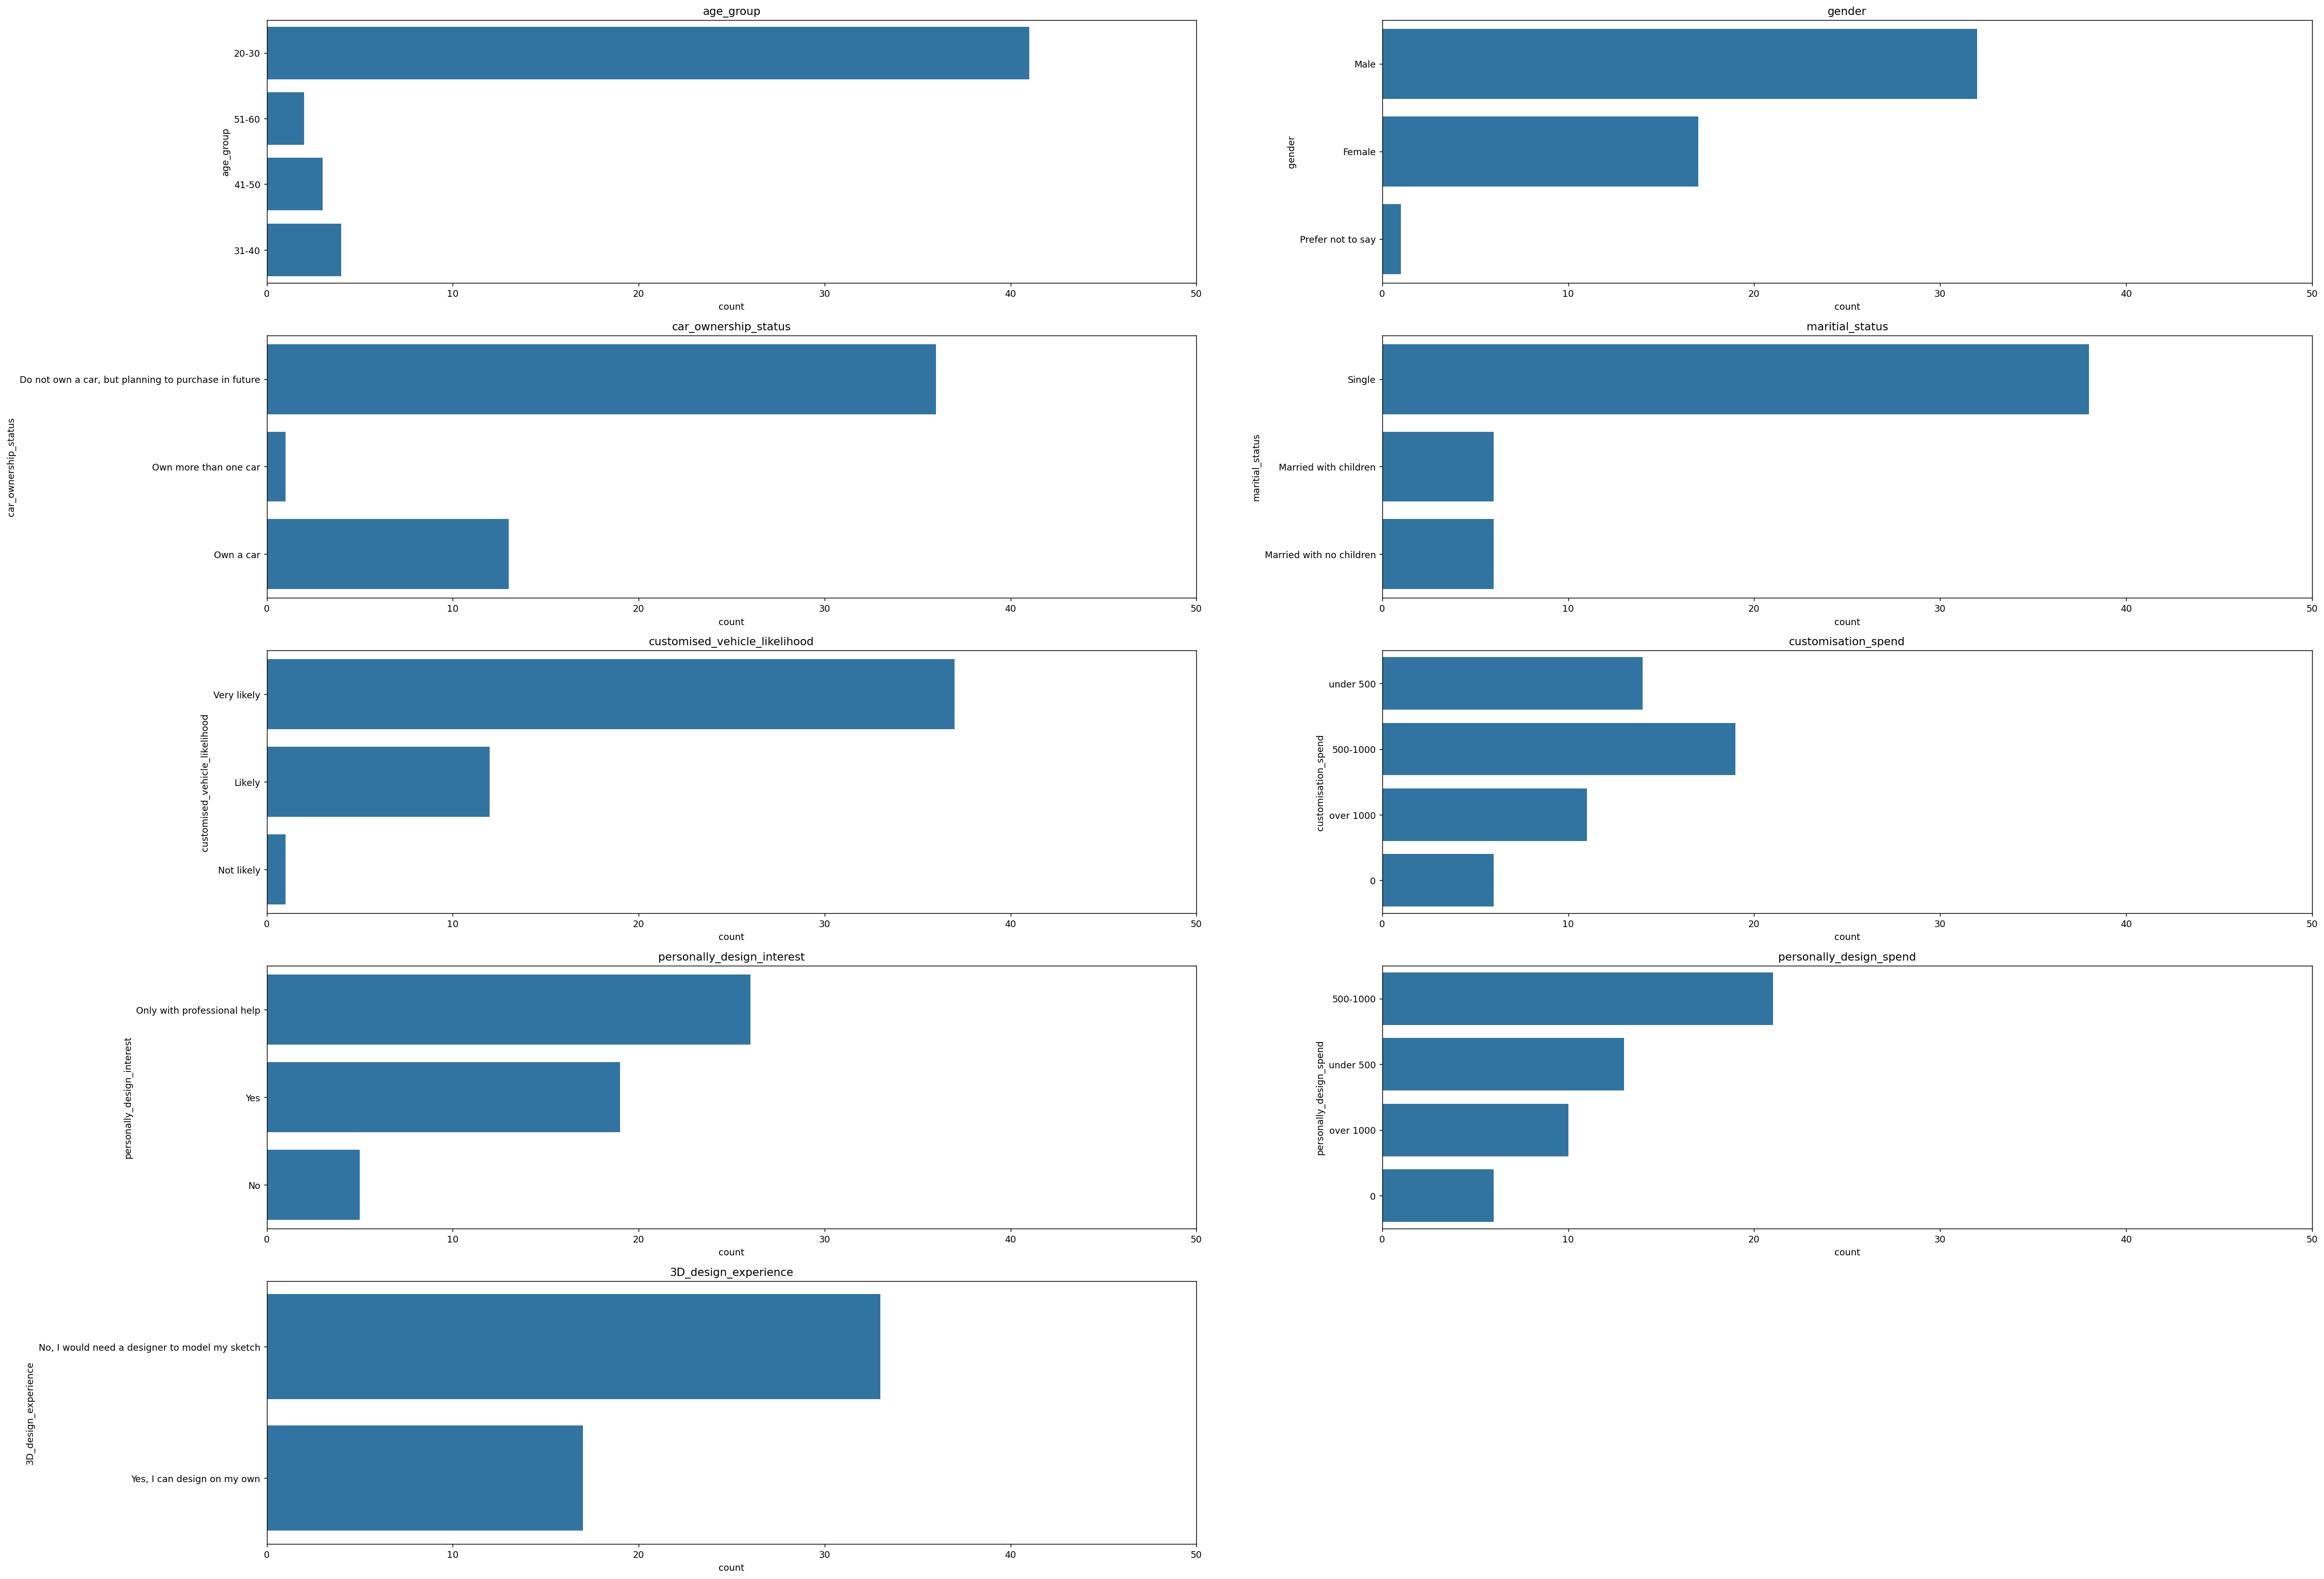

In [200]:
column_names = ['age_group', 
                'gender', 
                'car_ownership_status', 
                'maritial_status', 
                'customised_vehicle_likelihood', 
                'customisation_spend', 
                'personally_design_interest', 
                'personally_design_spend', 
                '3D_design_experience'
                ]
fig, ax = plt.subplots(dpi = 128, figsize=(40, 30))
plt.axis('off')
for i, col in enumerate(column_names):
  plt.subplot(5, 2, i+1)
  sns.countplot(data=data_mod_df, y=col, orient='h')
  plt.title(col)
  plt.xlim(0,50)
plt.show()

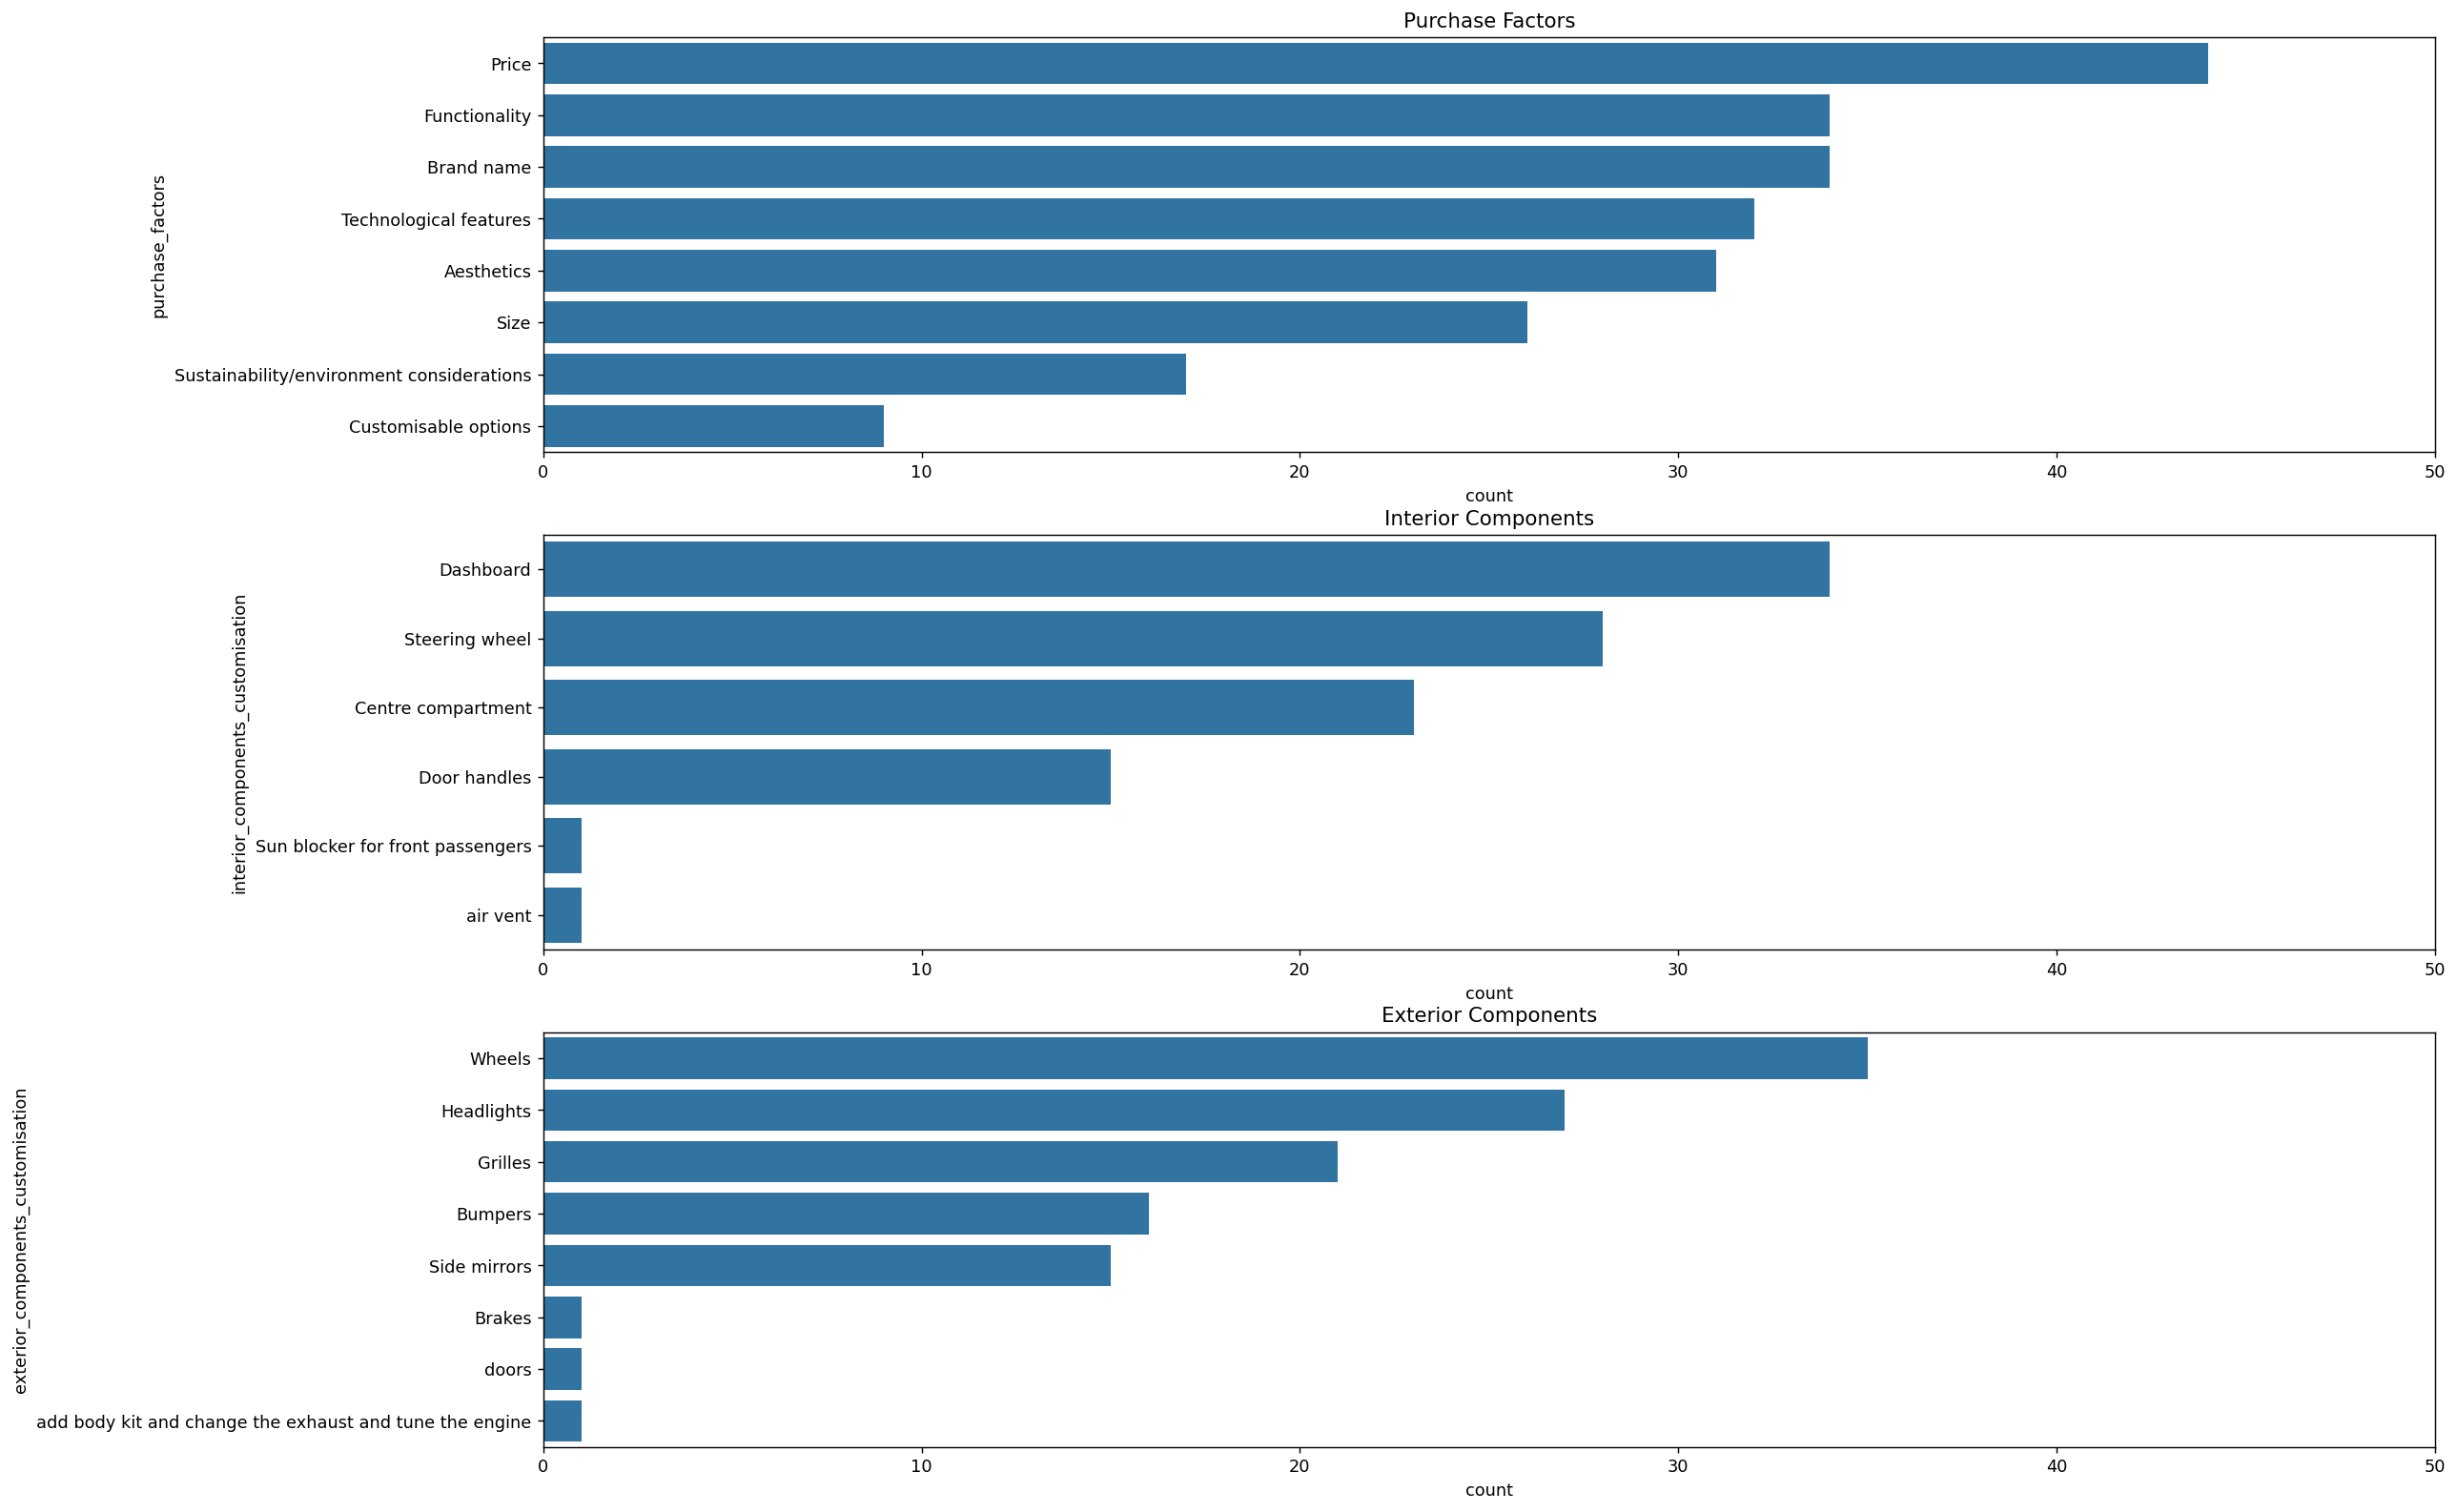

In [201]:
fig, ax = plt.subplots(dpi = 128, figsize=(20, 15))
plt.axis('off')
plt.subplot(3, 1, 1)
plt.title('Purchase Factors')
plt.xlim(0,50)
sns.barplot(data=purchase_factor_counts, orient='h')
plt.subplot(3, 1, 2)
plt.title('Interior Components')
plt.xlim(0,50)
sns.barplot(data=interior_components_counts, orient='h')
plt.subplot(3, 1, 3)
plt.title('Exterior Components')
plt.xlim(0,50)
sns.barplot(data=exterior_components_counts, orient='h')
plt.show()

## Encoding Data


In [202]:
from sklearn.preprocessing import LabelEncoder

In [203]:
def encode_data_by_count(column_name, data_frame):
  print("_"*120)
  label_encoder = LabelEncoder()
  encoded_column_name = column_name+"_encoded"
  data_frame[encoded_column_name] = label_encoder.fit_transform(data_frame[column_name])
  legend = data_frame[[column_name, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)
  data_frame.drop(column_name, axis=1, inplace=True)

def encode_by_label(df, unique_values, col):
  print("_"*120)
  encoded_column_name = col+"_encoded"
  for i, val in enumerate(unique_values):
    if val not in df[col].unique():
      print(f"'{val}' not in {col}")
      return
  label_mapping = {val: i for i, val in enumerate(unique_values)}
  df[encoded_column_name] = df[col].map(label_mapping)
  legend = df[[col, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)
  df.drop(col, axis=1, inplace=True)

In [204]:
encode_by_label(data_mod_df, ['20-30', '31-40', '41-50', '51-60'],'age_group')
encode_by_label(data_mod_df, ['Do not own a car, but planning to purchase in future', 'Own a car', 'Own more than one car'], 'car_ownership_status')
encode_by_label(data_mod_df, ['Not likely', 'Likely', 'Very likely'], 'customised_vehicle_likelihood')
encode_by_label(data_mod_df, ['0', 'under 500', '500-1000', 'over 1000'], 'customisation_spend')
encode_by_label(data_mod_df, ['No', 'Only with professional help', 'Yes'], 'personally_design_interest')
encode_by_label(data_mod_df, ['0', 'under 500', '500-1000', 'over 1000'], 'personally_design_spend')
encode_by_label(data_mod_df, ['No, I would need a designer to model my sketch', 'Yes, I can design on my own'], '3D_design_experience')

________________________________________________________________________________________________________________________
  age_group  age_group_encoded
0     20-30                  0
1     51-60                  3
2     41-50                  2
3     31-40                  1
________________________________________________________________________________________________________________________
                                car_ownership_status  \
0  Do not own a car, but planning to purchase in ...   
1                              Own more than one car   
2                                          Own a car   

   car_ownership_status_encoded  
0                             0  
1                             2  
2                             1  
________________________________________________________________________________________________________________________
  customised_vehicle_likelihood  customised_vehicle_likelihood_encoded
0                   Very likely                   

In [205]:
encode_data_by_count('gender', data_mod_df)
encode_data_by_count('maritial_status', data_mod_df)

________________________________________________________________________________________________________________________
              gender  gender_encoded
0               Male               1
1             Female               0
2  Prefer not to say               2
________________________________________________________________________________________________________________________
            maritial_status  maritial_status_encoded
0                    Single                        2
1     Married with children                        0
2  Married with no children                        1


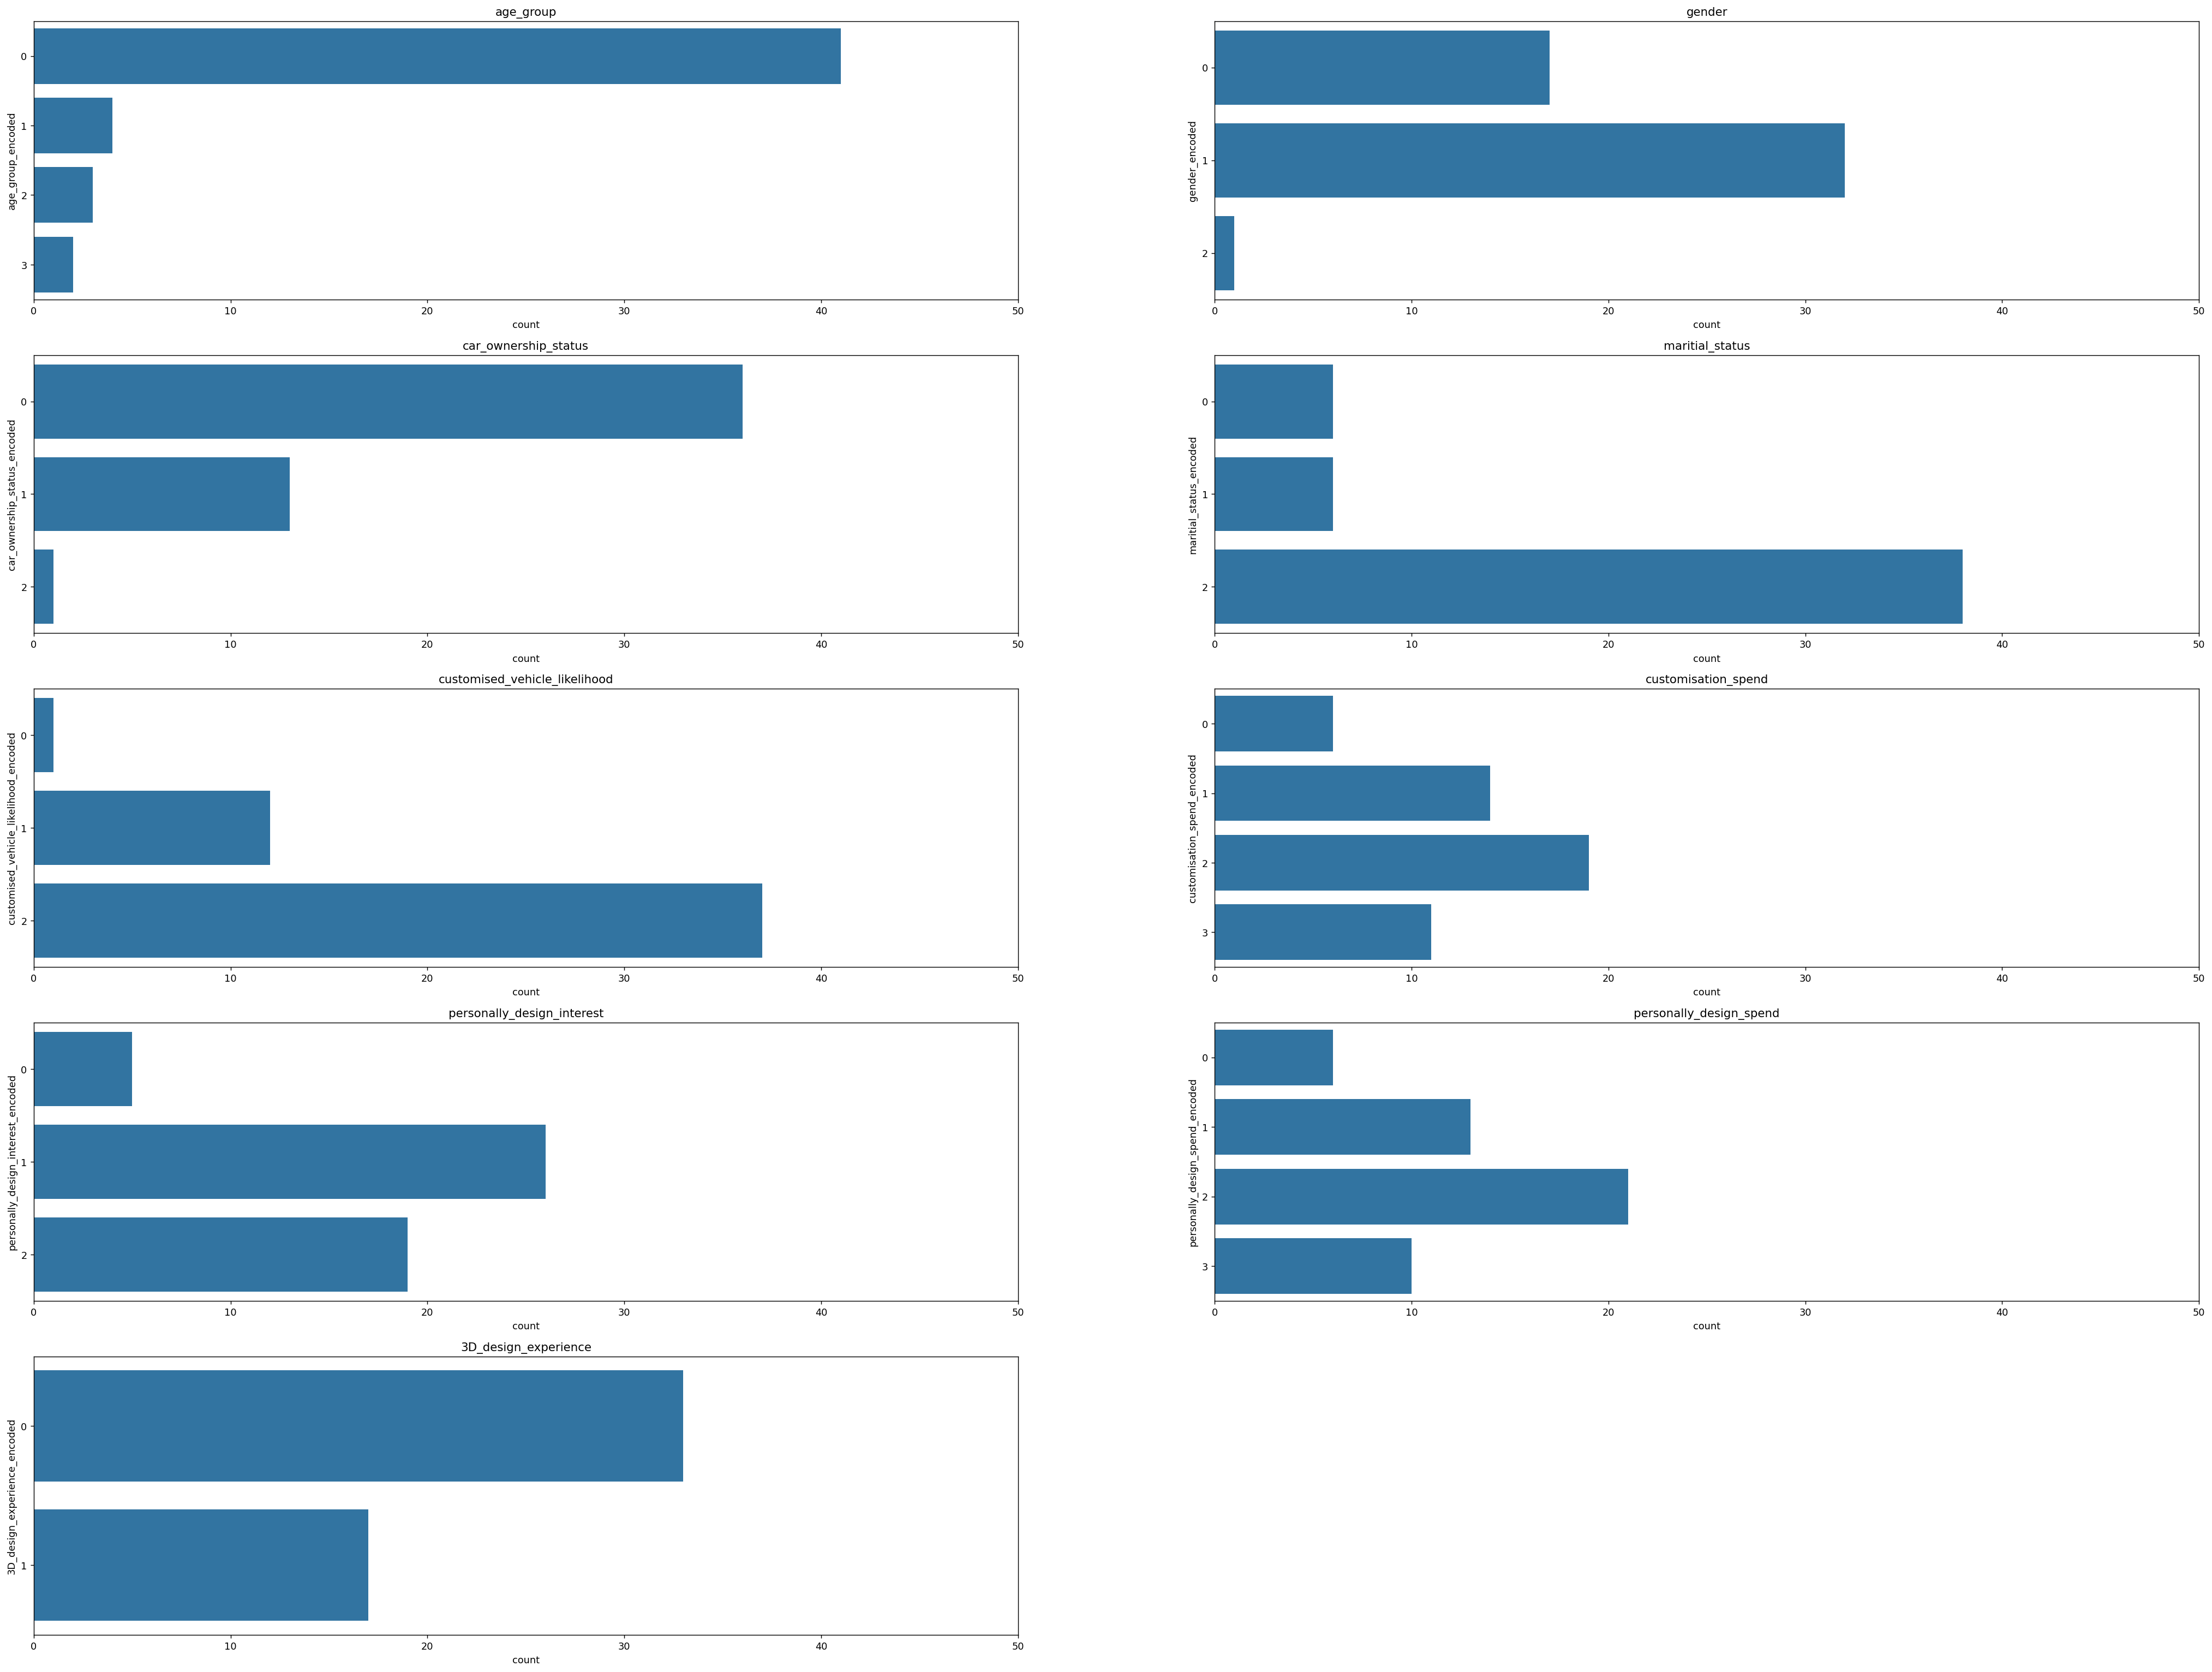

In [206]:
fig, ax = plt.subplots(dpi = 128, figsize=(40, 30))
plt.axis('off')
for i, col in enumerate(column_names):
  plt.subplot(5, 2, i+1)
  sns.countplot(data=data_mod_df, y=col+'_encoded', orient='h')
  plt.title(col)
  plt.xlim(0,50)
plt.show()

In [207]:
data_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   purchase_factors                       49 non-null     object
 1   exterior_components_customisation      49 non-null     object
 2   interior_components_customisation      50 non-null     object
 3   design_ideas                           17 non-null     object
 4   age_group_encoded                      50 non-null     int64 
 5   car_ownership_status_encoded           50 non-null     int64 
 6   customised_vehicle_likelihood_encoded  50 non-null     int64 
 7   customisation_spend_encoded            50 non-null     int64 
 8   personally_design_interest_encoded     50 non-null     int64 
 9   personally_design_spend_encoded        50 non-null     int64 
 10  3D_design_experience_encoded           50 non-null     int64 
 11  gender_encoded       

## Modelling


In [208]:
from sklearn.model_selection import train_test_split

predict likelihood of making customisation.
include: purchase_factors, age_group, car_ownership, 3D design experience, customised_vehicle_likelihood
exclude: exterior_components_customisation, interior_components_customisation,design_ideas, customisation_spend_encoded, customisation_spend, personally_design_interest_encoded, personally_design_spend_encoded


In [209]:
data_1 = data_mod_df.copy()
dropped_columns = [ 'exterior_components_customisation', 
                    'interior_components_customisation', 
                    'design_ideas', 
                    'customisation_spend_encoded', 
                    'personally_design_interest_encoded', 
                    'personally_design_spend_encoded']
data_1.drop(dropped_columns, axis=1, inplace=True)
data_1.dropna()
purchase_factors_dummies = pd.get_dummies(data=data_1['purchase_factors'].explode(), dtype=int, prefix='purchase_factors')
merged_df = purchase_factors_dummies.groupby(purchase_factors_dummies.index).sum()
data_1 = pd.concat([data_1, merged_df], axis=1)
data_1.drop('purchase_factors', axis=1, inplace=True)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   age_group_encoded                                           50 non-null     int64
 1   car_ownership_status_encoded                                50 non-null     int64
 2   customised_vehicle_likelihood_encoded                       50 non-null     int64
 3   3D_design_experience_encoded                                50 non-null     int64
 4   gender_encoded                                              50 non-null     int64
 5   maritial_status_encoded                                     50 non-null     int64
 6   purchase_factors_Aesthetics                                 50 non-null     int64
 7   purchase_factors_Brand name                                 50 non-null     int64
 8   purchase_factors_Custo

In [210]:
y = data_1['customised_vehicle_likelihood_encoded']
X = data_1.drop('customised_vehicle_likelihood_encoded', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((35, 13), (15, 13), (35,), (15,))

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_curve,roc_auc_score,confusion_matrix,classification_report

In [212]:
def model_evaluation(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f"Model: {model.__class__.__name__}")
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Precision Score: \n{precision_score(y_test, y_pred, average='weighted')}")
  print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
  print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")
  print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
  tp, fn, fp, tn = confusion_matrix(y_test,y_pred).reshape(-1)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  model_dict={'Model': [model.__class__.__name__], 'Accuracy': [round(accuracy,3)], 'F1_Score': [round(f1,3)], 'Precision': [round(precision,3)], 'Recall': [round(recall,3)]}
  try:
    model_df = pd.DataFrame(data=model_dict)
  except:
    print("Error creating model_df")
    print(model_dict)
    return
  return model_df

In [213]:
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])

In [214]:
log_regression = model_evaluation(LogisticRegression(), X_train, X_test, y_train, y_test)
res = pd.concat([res, log_regression], ignore_index=True)

Model: LogisticRegression
Accuracy: 0.7333333333333333
F1 Score: 0.6769230769230768
Precision Score: 
0.6285714285714286
Recall Score: 0.7333333333333333
Confusion Matrix: 
 [[ 0  3]
 [ 1 11]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.79      0.92      0.85        12

    accuracy                           0.73        15
   macro avg       0.39      0.46      0.42        15
weighted avg       0.63      0.73      0.68        15



/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_49062/3653166030.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, log_regression], ignore_index=True)


In [217]:
dec_tree = model_evaluation(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
res = pd.concat([res, dec_tree], ignore_index=True)

Model: DecisionTreeClassifier
Accuracy: 0.6666666666666666
F1 Score: 0.6984126984126984
Precision Score: 
0.7777777777777778
Recall Score: 0.6666666666666666
Confusion Matrix: 
 [[2 1]
 [4 8]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.33      0.67      0.44         3
           2       0.89      0.67      0.76        12

    accuracy                           0.67        15
   macro avg       0.61      0.67      0.60        15
weighted avg       0.78      0.67      0.70        15



In [218]:
random_forrest = model_evaluation(RandomForestClassifier(), X_train, X_test, y_train, y_test)
res = pd.concat([res, random_forrest], ignore_index=True)

Model: RandomForestClassifier
Accuracy: 0.8
F1 Score: 0.7840000000000001
Precision Score: 
0.7769230769230769
Recall Score: 0.8
Confusion Matrix: 
 [[ 1  2]
 [ 1 11]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.85      0.92      0.88        12

    accuracy                           0.80        15
   macro avg       0.67      0.62      0.64        15
weighted avg       0.78      0.80      0.78        15



In [219]:
extra_trees = model_evaluation(ExtraTreesClassifier(), X_train, X_test, y_train, y_test)
res = pd.concat([res, pd.DataFrame(extra_trees)], ignore_index=True)

Model: ExtraTreesClassifier
Accuracy: 0.7333333333333333
F1 Score: 0.7333333333333333
Precision Score: 
0.7333333333333333
Recall Score: 0.7333333333333333
Confusion Matrix: 
 [[ 1  2]
 [ 2 10]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.33      0.33      0.33         3
           2       0.83      0.83      0.83        12

    accuracy                           0.73        15
   macro avg       0.58      0.58      0.58        15
weighted avg       0.73      0.73      0.73        15



In [220]:
k_neighbours = model_evaluation(KNeighborsClassifier(), X_train, X_test, y_train, y_test)
res = pd.concat([res, pd.DataFrame(k_neighbours)], ignore_index=True)

Model: KNeighborsClassifier
Accuracy: 0.9333333333333333
F1 Score: 0.928
Precision Score: 
0.9384615384615385
Recall Score: 0.9333333333333333
Confusion Matrix: 
 [[ 2  1]
 [ 0 12]]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.92      1.00      0.96        12

    accuracy                           0.93        15
   macro avg       0.96      0.83      0.88        15
weighted avg       0.94      0.93      0.93        15



In [221]:
gaussian = model_evaluation(GaussianNB(), X_train, X_test, y_train, y_test)
res = pd.concat([res, pd.DataFrame(gaussian)], ignore_index=True)

Model: GaussianNB
Accuracy: 0.7333333333333333
F1 Score: 0.6769230769230768
Precision Score: 
0.6285714285714286
Recall Score: 0.7333333333333333
Confusion Matrix: 
 [[ 0  3]
 [ 1 11]]
Classification Report: 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.79      0.92      0.85        12

    accuracy                           0.73        15
   macro avg       0.39      0.46      0.42        15
weighted avg       0.63      0.73      0.68        15



In [222]:
display(res)

,Model,Accuracy,F1_Score,Precision,Recall
0,LogisticRegression,0.733,0.677,0.629,0.733
1,DecisionTreeClassifier,0.667,0.698,0.778,0.667
2,RandomForestClassifier,0.800,0.784,0.777,0.800
3,ExtraTreesClassifier,0.733,0.733,0.733,0.733
4,KNeighborsClassifier,0.933,0.928,0.938,0.933
5,GaussianNB,0.733,0.677,0.629,0.733


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

print(fuzz.ratio("this is a test", "this is sdakf a test"))


82
